In [1]:
import torch
import gpytorch
import copy
from matplotlib import pyplot as plt
import itertools
import numpy as np
import pandas as pd
from skimage.measure import block_reduce
from datetime import datetime
import gc
from src.utils import *
plt.style.use('classic')
set_gpytorch_settings(False)

Scale Max: 1677108352.0
 Scale Min: 1349069952.0
 Scale Factor: 328038400.0


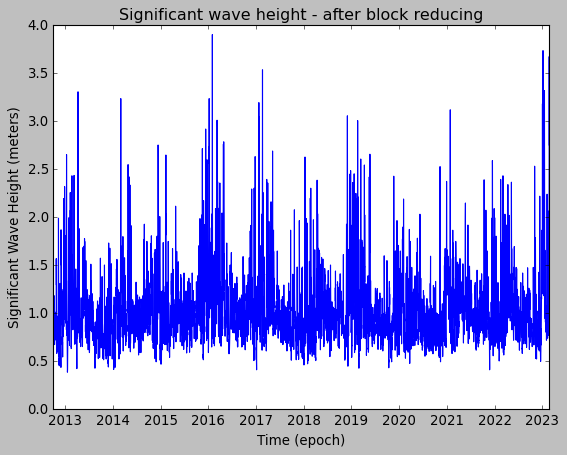

Before Block Reduce: (174818, 2)
After Block Reduce: (7285, 2)
Number of Nans: 0
Start Time: 2012-09-30 16:55:44
End Time: 2023-02-22 23:25:52
Number of Days: 3642.0416666666665
Time Period (Days): 3797.312592592593


In [2]:
# Reading data file and cleaning missing values
df = pd.read_feather('../Data/feather/46221_9999_wave_height.feather')
parameters_wave = ['time', 'wave_height']
parameters_temp = ['time', 'sea_surface_temperature']
df_as_np = df \
    .loc[:, parameters_wave] \
    .astype(float) \
    .replace(to_replace=[999.0, 99.0, 9999.0], value=np.nan) \
    .to_numpy()
using_sk = block_reduce(df_as_np, block_size=(24, 1), func=np.mean).astype(float)
X = torch.tensor(using_sk[:-1, 0]).float().cuda()
y = torch.tensor(using_sk[:-1, 1]).float().cuda()
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

X = X[~torch.any(y.isnan(), dim=1)]
y = y[~torch.any(y.isnan(), dim=1)]
y = y.flatten()
X_old = X


# Helper functions
def scaler(a, X_old=X_old, center=True):
    if center is True:
        a = a - X_old.min(0).values
    return a / (X_old.max(0).values - X_old.min(0).values)


def add_new_kernel_term(original_kernel, new_kernel_term, operation):
    return str(original_kernel) + str(operation) + str(new_kernel_term)


# GP Model Declaration
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# Scale the time axis and log transform the Y-values
X = scaler(X, X_old)
y = y.log()

# max, min, and scale factor declaration
scaler_max = X_old.max(0).values.item()
scaler_min = X_old.min(0).values.item()
scale_factor = scaler_max - scaler_min
scaler_consts = [scaler_max, scaler_min, scale_factor]
print(f'Scale Max: {scaler_max}\n Scale Min: {scaler_min}\n Scale Factor: {scale_factor}')
temp_for_plotting = pd.Series(using_sk[:-1, 0] * 1e9, dtype='datetime64[ns]')
plt.plot(temp_for_plotting, using_sk[:-1, 1])
plt.xlabel("Time (epoch)")
plt.ylabel("Significant Wave Height (meters)")
plt.title(f'Significant wave height - after block reducing')
plt.show()

print(
    f'Before Block Reduce: {df_as_np.shape}\n'
    f'After Block Reduce: {using_sk.shape}\n'
    f'Number of Nans: {np.count_nonzero(np.isnan(df_as_np))}\n'
    f'Start Time: {datetime.fromtimestamp(df_as_np[0, 0])}\n'
    f'End Time: {datetime.fromtimestamp(df_as_np[-1, 0])}\n'
    f'Number of Days: {df_as_np.shape[0] / 48}\n'
    f'Time Period (Days): {(df_as_np[-1, 0] - df_as_np[0, 0]) / 24 / 60 / 60}')

In [3]:
# Prediction range, training and test set define (14, 3, 365)
predict_days_out = 28
test_n = 2 * predict_days_out
train_x = X[test_n:].contiguous().cuda()
train_y = y[test_n:].contiguous().cuda()
test_x = X[-test_n:].contiguous().cuda()
test_y = y[-test_n:].contiguous().cuda()

# Generate the train_loader and train_dataset
train_loader, train_dataset, test_loader, test_dataset = create_train_loader_and_dataset(
    train_x, train_y, test_x, test_y)
data_compact = [train_x, train_y, test_x, test_y, train_loader, train_dataset, test_loader, test_dataset]

In [4]:
def search_for_min_BIC(
        possible_kernel_list, possible_kernel_operations,
        kernel_str_running_start, bic_values_list,
        data, scale, outer_count, initial_lr=0.01, epoch_iter=1000):
    trial_n = 0
    trial_hist = []
    for kernel_ops_i, iter_operations in enumerate(possible_kernel_operations):
        for kernel_term_i, iter_terms in enumerate(possible_kernel_list):
            if (kernel_term_i == 0) and (kernel_ops_i == 0):
                kernel_str_current = kernel_str_running_start
            else:
                kernel_str_current = add_new_kernel_term(
                    kernel_str_running_start, iter_terms, iter_operations)
            exact_gp_obj = TrainTestPlotSaveExactGP(
                ExactGPModel,
                kernel=kernel_str_current,
                train_x=data[0], train_y=data[1], test_x=data[2], test_y=data[3],
                scaler_min=scale[1], scaler_max=scale[0],
                num_iter=epoch_iter,
                lr=initial_lr,  # lr=0.0063, #lr=0.01,
                name=kernel_str_current,
                save_loss_values="save",
                use_scheduler=True)
            bic_at_current, hyper_vals = exact_gp_obj.run_train_test_plot_kernel(set_xlim=[0.96, 1])
            print("Iterations Number(n): ", outer_count, trial_n, "Learning Rate: ", initial_lr)
            print("Kernel Structure (Old Best): ", kernel_str_running_start, "\n BIC: ", bic_values[-1])
            print("Kernel Structure (Current Trial): ", kernel_str_current, "\n BIC: ", bic_at_current)
            trial_hist.append([
                (outer_count, trial_n), kernel_str_current,
                bic_at_current,
                hyper_vals,])
                # exact_gp_obj.kernel])
            if bic_at_current < bic_values_list[-1]:
                bic_values_list.append(bic_at_current)
                if kernel_str_running_start != kernel_str_current:
                    del exact_gp_obj
                    gc.enable()
                    gc.collect()
                    torch.cuda.empty_cache()
                    return kernel_str_running_start, pd.DataFrame(trial_hist)
                kernel_str_running_start = kernel_str_current
            trial_n += 1
            del exact_gp_obj
            gc.enable()
            gc.collect()
            torch.cuda.empty_cache()
    return kernel_str_running_start, pd.DataFrame(trial_hist)
# List of possible Kernels operations
kernel_operations = ["+", "*"]

# List of possible Kernels terms
# kernel_list = ["Per_Arb*RBF", "Per_Month*RBF", "Per_Year*RBF", "Per_Week*RBF"]
kernel_list = [
    "RFF", "RQ",  # Varying Length Scales of the RBF Kernel
    "RBF", "Mat_2.5", "Mat_1.5", "Mat_0.5",  # Smoothing Kernels of the Matern class
    "AR2", "Min",  # Speciality Kernels
    "Per_Arb", "Per_Year", "Per_Season", "Per_Month",  "Per_Week", "Per_Unbounded"]  # Periodic Kernels of Varying Period constraints

# Initial Kernel Trial
# kernel_str_running = "RBF+Per_Month*RBF+AR2*RFF+Per_Year"
# kernel_str_running = "RFF"
kernel_str_running = "AR2*RFF"
# kernel_str_running = "AR2*RFF+RQ"
# kernel_str_running = "RBF+Mat_2.5*Per_Arb"
# kernel_str_running = "AR2*RFF+RQ*AR2+RFF"

In [ ]:
# Initializing empty list to record values
save_history = pd.DataFrame()
bic_values = [10000]
initial_learning_rate = 0.01  # 0.0063 # initial learning rate
with_and_without_scheduler = [True]
file_save_name = \
    f'../Past_Trials/ResultsStartingAt_' \
    f'{kernel_str_running.replace("*","x").replace("+","add")}_' \
    f'{datetime.now().strftime("%Y%m%d_%H")}'
for i in range(3):
    new_kernel_best = kernel_str_running
    kernel_str_running, path_history = search_for_min_BIC(
        kernel_list, kernel_operations,
        new_kernel_best, bic_values,
        data_compact, scaler_consts, i,
        initial_lr=initial_learning_rate, epoch_iter=1000)
    save_history = pd.concat([save_history, path_history])
    save_history.to_csv(f'{file_save_name}.csv')
column_names = [
    'Trial_Num', 'Kernel_Name', 'BIC', 'Hyper_Parameters']
save_history.to_csv(f'{file_save_name}.csv')
save_history

Using available CUDA


Training exactGP: AR2*RFF:  96%|█████████▌| 959/1000 [04:33<00:11,  3.60it/s]

In [ ]:
save_history